# 人脸识别-olivetti数据集  
olivetti数据集中包含400张图片，每张图片数据维度是[64，64]。总共有40个人的照片，每个人各10张。


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=np.load('./olivetti_faces.npy')
target=np.load('./olivetti_faces_target.npy')

In [3]:
data.shape

(400, 64, 64)

In [4]:
target.shape

(400,)

可视化数据

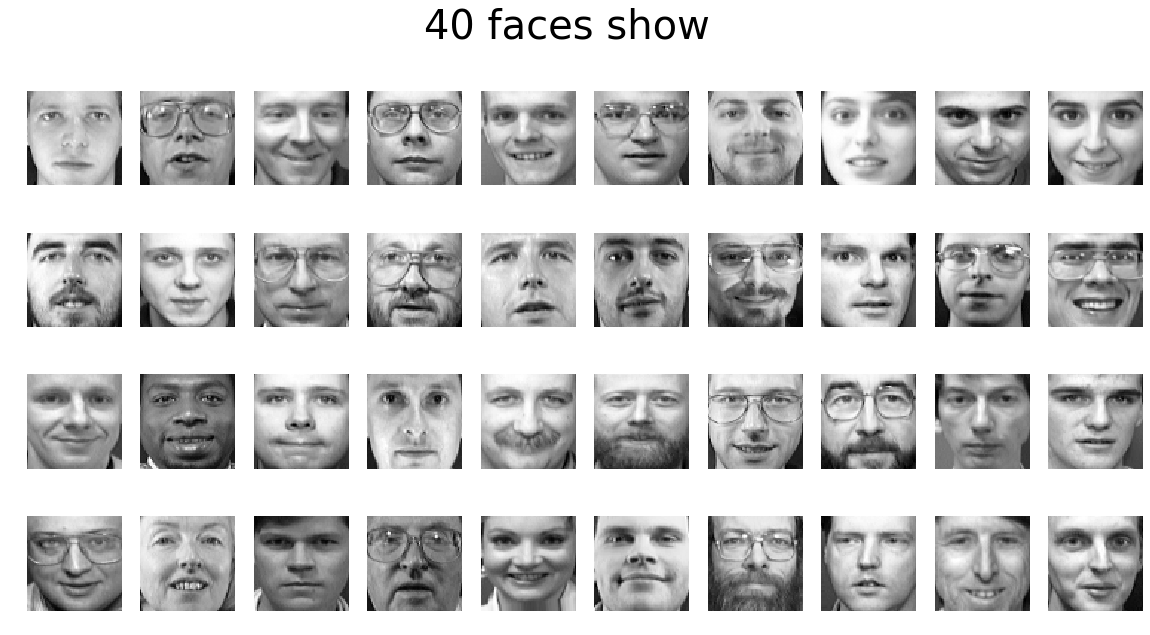

In [5]:
fig=plt.figure(figsize=(20,10))
row=4
coloum=10
for i in range(row*coloum):
    img=data[10*i,:,:]
    plt.subplot(row,coloum,i+1)
    plt.imshow(img,plt.get_cmap('gray'))
    plt.axis('off')
plt.suptitle('40 faces show',fontsize=40)
plt.show()

划分数据集

In [6]:
x_data=data.copy()
y_data=target.reshape(-1,1)

x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.3,stratify=target,random_state=78)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(280, 64, 64)
(120, 64, 64)
(280, 1)
(120, 1)


lr rf knn输入的训练数据维度是二维的，所以这里要reshape。

In [7]:
x_train_=x_train.reshape(x_train.shape[0],-1)
x_test_=x_test.reshape(x_test.shape[0],-1)

print(x_train_.shape)
print(x_test_.shape)

(280, 4096)
(120, 4096)


lr:逻辑回归

In [8]:
lr=LogisticRegression(max_iter=1000)
lr.fit(x_train_,y_train)
lr_score=lr.score(x_test_,y_test)
print('lr score:',lr_score)

lr score: 0.9583333333333334


rf:随机森林

In [9]:
rf=RandomForestClassifier(n_estimators=400,random_state=78)
rf.fit(x_train_,y_train)
rf_score=rf.score(x_test_,y_test)
print('rf score:',rf_score)

rf score: 0.9666666666666667


knn:k近邻

In [10]:
knn=KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train_,y_train)
knn_score=knn.score(x_test_,y_test)
print('knn score:',knn_score)

knn score: 0.9333333333333333


cnn:卷积神经网络

In [11]:
import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
torch.manual_seed(78)

数据类型转换 ndarray->tensor

In [12]:
x_train=torch.from_numpy(x_train).float().unsqueeze(1)
x_test=torch.from_numpy(x_test).float().unsqueeze(1)
y_train=torch.from_numpy(y_train).long().squeeze()
y_test=torch.from_numpy(y_test).long().squeeze()

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([280, 1, 64, 64])
torch.Size([120, 1, 64, 64])
torch.Size([280])
torch.Size([120])


构建数据集

In [16]:
# 没有做transform
class mydataset(Dataset):
    def __init__(self,tp='train'):
        self.x_train=x_train
        self.x_test=x_test
        self.y_train=y_train
        self.y_test=y_test
        self.type=tp
        
    def __getitem__(self, idx):
        if self.type=='train':
            return self.x_train[idx],self.y_train[idx]
        elif self.type=='test':
            return self.x_test[idx],self.y_test[idx]
    
    def __len__(self):
        if self.type=='train':
            return len(self.x_train)
        elif self.type=='test':
            return len(self.x_test)

train_face_dataset=mydataset(tp='train')
train_dataloader=DataLoader(dataset=train_face_dataset,batch_size=10,shuffle=True)
test_face_dataset=mydataset(tp='test')
test_dataloader=DataLoader(dataset=test_face_dataset,batch_size=10,shuffle=False)

搭建网络

In [17]:
class cnn(nn.Module):
    def __init__(self,num_classes=40):
        super(cnn, self).__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=3,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=3,out_channels=5,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc=nn.Sequential(
            nn.Linear(1280,512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(512,num_classes)
        )
    def forward(self, x):
        x=self.conv(x)
        x=x.reshape(x.shape[0],-1)
        x=self.fc(x)
        return x

device=torch.device('cuda:0')
net=cnn().to(device)
optimizer=optim.Adam(net.parameters(),lr=0.001,weight_decay=0.0005)
criterion=nn.CrossEntropyLoss().to(device)

训练测试 最好添加一个验证集 可以用random_split来切分

In [18]:
epoch=100
for e in range(epoch):
    net.train()
    running_train_loss=0.0
    total=0
    correct=0
    for batchidx,(batchdata,batchlabel) in enumerate(train_dataloader):
        batchdata,batchlabel=batchdata.to(device),batchlabel.to(device)
        output=net(batchdata)
        loss=criterion(output,batchlabel)
        
        pred=torch.argmax(output,dim=1)
        correct+=torch.eq(pred,batchlabel).sum().cpu().item()
        total+=len(batchdata)
        running_train_loss+=loss.item()*len(batchdata)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       

    train_loss=running_train_loss/float(len(train_dataloader.dataset))
    train_accuracy=float(correct)/float(total)
    print('epoch:{},loss:{:.4f},correct:{}/{}.accuracy:{:.4f}'.format(e,train_loss,correct,total,train_accuracy))

net.eval()
total=0
correct=0
for batchidx,(batchdata,batchlabel) in enumerate(test_dataloader):
    batchdata,batchlabel=batchdata.to(device),batchlabel.to(device)
    output=net(batchdata)
    loss=criterion(output,batchlabel)
    
    pred=torch.argmax(output,dim=1)
    correct+=torch.eq(pred,batchlabel).sum().cpu().item()
    total+=len(batchdata)
test_accuracy=float(correct)/float(total)
print('test correct:{}/{}.accuracy:{:.4f}'.format(correct,total,test_accuracy))

epoch:0,loss:3.7045,correct:7/280.accuracy:0.0250
epoch:1,loss:3.6596,correct:16/280.accuracy:0.0571
epoch:2,loss:3.5382,correct:32/280.accuracy:0.1143
epoch:3,loss:3.1842,correct:55/280.accuracy:0.1964
epoch:4,loss:2.7334,correct:70/280.accuracy:0.2500
epoch:5,loss:2.2810,correct:103/280.accuracy:0.3679
epoch:6,loss:1.9290,correct:121/280.accuracy:0.4321
epoch:7,loss:1.5938,correct:163/280.accuracy:0.5821
epoch:8,loss:1.3077,correct:186/280.accuracy:0.6643
epoch:9,loss:1.1113,correct:205/280.accuracy:0.7321
epoch:10,loss:0.9350,correct:202/280.accuracy:0.7214
epoch:11,loss:0.7760,correct:230/280.accuracy:0.8214
epoch:12,loss:0.6691,correct:229/280.accuracy:0.8179
epoch:13,loss:0.5567,correct:239/280.accuracy:0.8536
epoch:14,loss:0.4495,correct:247/280.accuracy:0.8821
epoch:15,loss:0.3600,correct:260/280.accuracy:0.9286
epoch:16,loss:0.3804,correct:251/280.accuracy:0.8964
epoch:17,loss:0.2989,correct:266/280.accuracy:0.9500
epoch:18,loss:0.2275,correct:264/280.accuracy:0.9429
epoch:19,